In [1]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_HIGHTOL.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv_HIGHTOL.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545489,15563.916192,266.913396,-1.142984,2.852848,0.048528
2,30572.240101,28909.065576,496.928457,-2.127756,2.228986,0.039518
3,17596.058985,38144.724801,671.355898,-2.813645,1.287414,0.027234
4,2068.443209,41949.722913,775.646911,-3.098444,0.161674,0.012698
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


In [3]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, predicted_feature]) # 2 stands for prediction of Z!!! (3rd col)
    return np.array(dataX), np.array(dataY)

In [4]:
# Function

def train_vector(df, predicted_feature):
    
    # load the dataset
    dataset = df.values
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.8) 
    test_size = len(dataset) - train_size
    train=dataset[0 : train_size]
    test=dataset[train_size - 60 : ]
    
    #Scale the data
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    # reshape into X=t and Y=t+1
    look_back = 60 # this is the window
    trainX, trainY = create_dataset(train, look_back)  
    testX, testY = create_dataset(test, look_back)
    # reshape input to be  [length of train/test data, window size (def=60), features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
    testX = np.reshape(testX, (testX.shape[0],look_back, 6))
    
    # Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    history=model.fit(trainX, trainY, batch_size=256, epochs=100)

    # Plot Training Loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss']) # add validation loss
    #plt.plot(history.history['val_loss']) # add validation loss
    #plt.title('Autoencoder model training losses', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.legend(['Loss (Mean Squared Error)'], loc='upper right', fontsize=18)
    plt.show()
    
    predictions = model.predict(testX)
    predict_ext = np.zeros((len(predictions), 6))
    predict_ext[:,predicted_feature] = predictions[:,0]
    predictions = scaler.inverse_transform(predict_ext)[:,predicted_feature]
    
    testY_extended = np.zeros((len(testY),6))
    testY_extended[:,predicted_feature]=testY
    testY=scaler.inverse_transform(testY_extended)[:,predicted_feature]
    
    rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
    print(f'RMSE for feature {predicted_feature} is: ' + str(rmse))
    
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    df_pred[str(predicted_feature)]=pred_s
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

Epoch 1/100
3/3 [==============================] - 0s 129ms/step - loss: 0.1890
Epoch 2/100
3/3 [==============================] - 0s 123ms/step - loss: 0.1087
Epoch 3/100
3/3 [==============================] - 0s 127ms/step - loss: 0.0840
Epoch 4/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0477
Epoch 5/100
3/3 [==============================] - 0s 111ms/step - loss: 0.0280
Epoch 6/100
3/3 [==============================] - 0s 113ms/step - loss: 0.0089
Epoch 7/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0075
Epoch 8/100
3/3 [==============================] - 0s 122ms/step - loss: 0.0084
Epoch 9/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0102
Epoch 10/100
3/3 [==============================] - 0s 112ms/step - loss: 0.0043
Epoch 11/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0033
Epoch 12/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0024
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 134ms/step - loss: 7.2923e-05
Epoch 99/100
3/3 [==============================] - 0s 143ms/step - loss: 9.1145e-05
Epoch 100/100
3/3 [==============================] - 0s 139ms/step - loss: 7.3574e-05


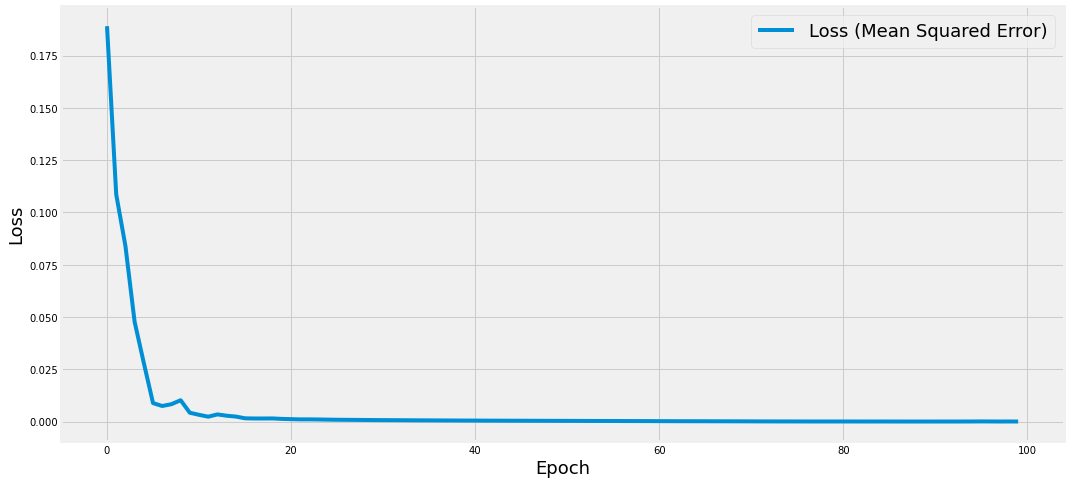

RMSE for feature 0 is: 841.9825723688572
Epoch 1/100
3/3 [==============================] - 1s 207ms/step - loss: 0.3442
Epoch 2/100
3/3 [==============================] - 1s 244ms/step - loss: 0.1873
Epoch 3/100
3/3 [==============================] - 1s 234ms/step - loss: 0.0946
Epoch 4/100
3/3 [==============================] - 1s 220ms/step - loss: 0.0960
Epoch 5/100
3/3 [==============================] - 1s 213ms/step - loss: 0.0794
Epoch 6/100
3/3 [==============================] - 1s 197ms/step - loss: 0.0514
Epoch 7/100
3/3 [==============================] - 1s 203ms/step - loss: 0.0400
Epoch 8/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0272
Epoch 9/100
3/3 [==============================] - 1s 184ms/step - loss: 0.0102
Epoch 10/100
3/3 [==============================] - 1s 183ms/step - loss: 0.0067
Epoch 11/100
3/3 [==============================] - 1s 172ms/step - loss: 0.0038
Epoch 12/100
3/3 [==============================] - 1s 178ms/step - loss: 0.0

3/3 [==============================] - 0s 128ms/step - loss: 4.5265e-04
Epoch 99/100
3/3 [==============================] - 0s 122ms/step - loss: 4.4761e-04
Epoch 100/100
3/3 [==============================] - 0s 128ms/step - loss: 4.4199e-04


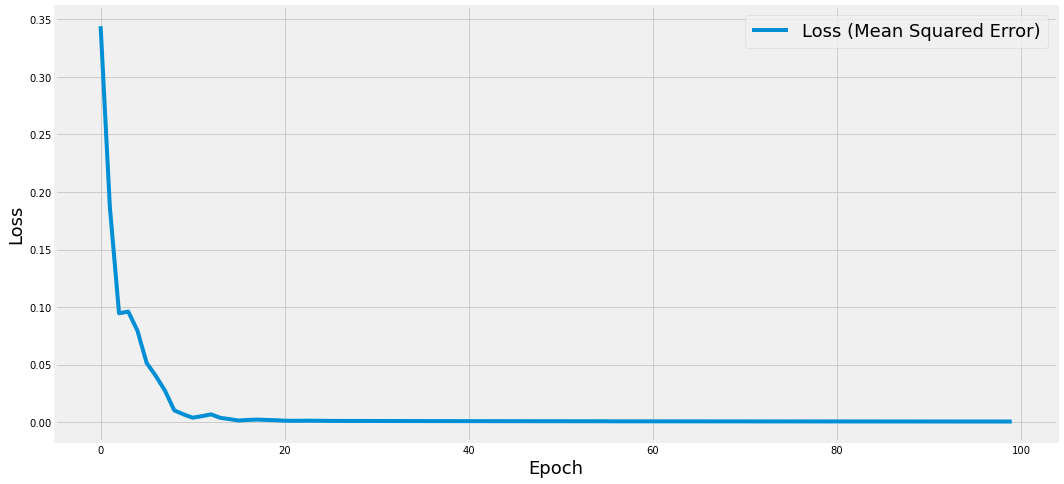

RMSE for feature 1 is: 886.7771159904007
Epoch 1/100
3/3 [==============================] - 1s 195ms/step - loss: 0.1650
Epoch 2/100
3/3 [==============================] - 1s 204ms/step - loss: 0.0845
Epoch 3/100
3/3 [==============================] - 1s 209ms/step - loss: 0.0392
Epoch 4/100
3/3 [==============================] - 1s 191ms/step - loss: 0.0482
Epoch 5/100
3/3 [==============================] - 1s 192ms/step - loss: 0.0328
Epoch 6/100
3/3 [==============================] - 1s 195ms/step - loss: 0.0227
Epoch 7/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0242
Epoch 8/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0166
Epoch 9/100
3/3 [==============================] - 1s 168ms/step - loss: 0.0133
Epoch 10/100
3/3 [==============================] - 1s 174ms/step - loss: 0.0131
Epoch 11/100
3/3 [==============================] - 1s 174ms/step - loss: 0.0100
Epoch 12/100
3/3 [==============================] - 0s 165ms/step - loss: 0.0

3/3 [==============================] - 0s 125ms/step - loss: 4.5777e-05
Epoch 99/100
3/3 [==============================] - 0s 128ms/step - loss: 4.7607e-05
Epoch 100/100
3/3 [==============================] - 0s 128ms/step - loss: 4.9304e-05


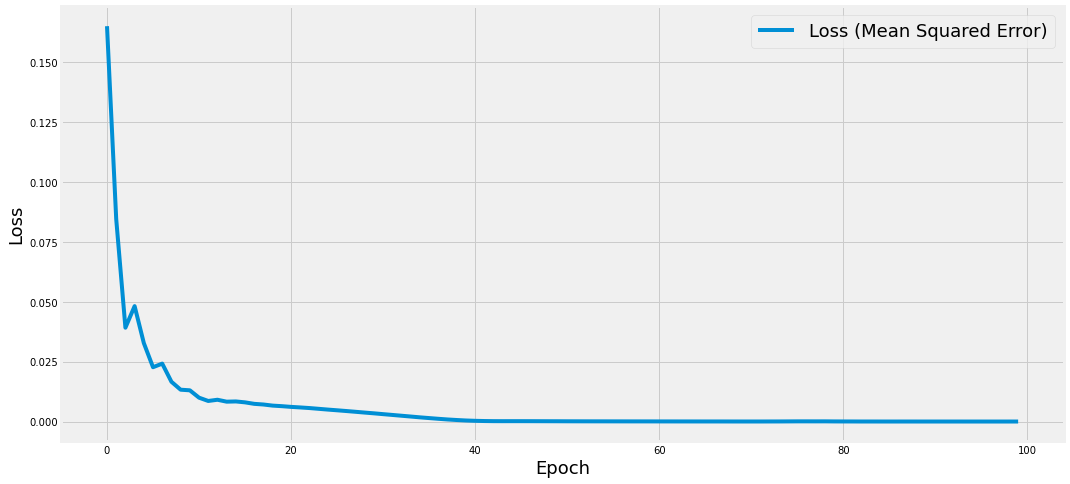

RMSE for feature 2 is: 737.3177271874241
Epoch 1/100
3/3 [==============================] - 1s 197ms/step - loss: 0.2439
Epoch 2/100
3/3 [==============================] - 1s 212ms/step - loss: 0.1536
Epoch 3/100
3/3 [==============================] - 1s 216ms/step - loss: 0.0949
Epoch 4/100
3/3 [==============================] - 1s 206ms/step - loss: 0.0972
Epoch 5/100
3/3 [==============================] - 1s 195ms/step - loss: 0.0588
Epoch 6/100
3/3 [==============================] - 1s 200ms/step - loss: 0.0467
Epoch 7/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0340
Epoch 8/100
3/3 [==============================] - 1s 188ms/step - loss: 0.0150
Epoch 9/100
3/3 [==============================] - 1s 168ms/step - loss: 0.0105
Epoch 10/100
3/3 [==============================] - 1s 179ms/step - loss: 0.0044
Epoch 11/100
3/3 [==============================] - 1s 170ms/step - loss: 0.0097
Epoch 12/100
3/3 [==============================] - 1s 178ms/step - loss: 0.0

3/3 [==============================] - 0s 122ms/step - loss: 2.4234e-04
Epoch 100/100
3/3 [==============================] - 0s 125ms/step - loss: 2.4204e-04


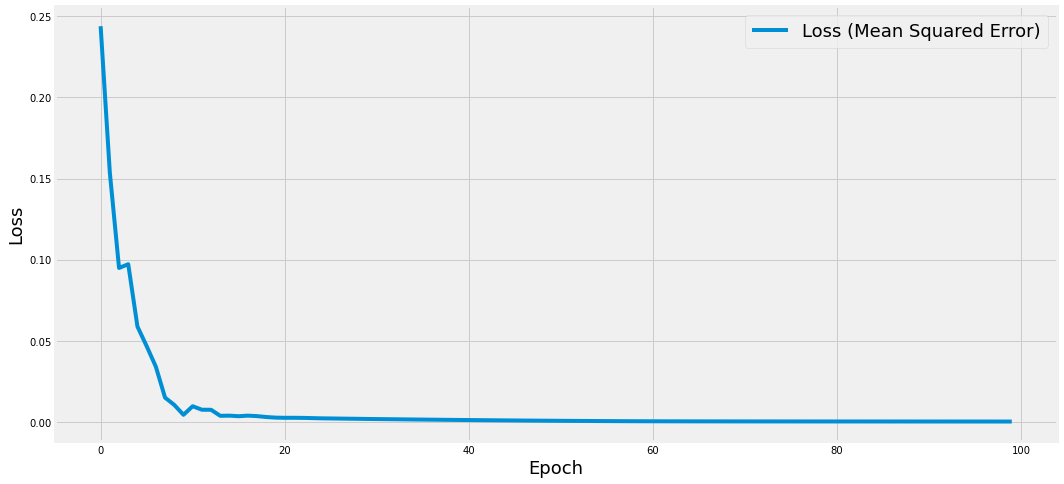

RMSE for feature 3 is: 0.0942171643472404
Epoch 1/100
3/3 [==============================] - 1s 213ms/step - loss: 0.2469
Epoch 2/100
3/3 [==============================] - 1s 233ms/step - loss: 0.1283
Epoch 3/100
3/3 [==============================] - 1s 218ms/step - loss: 0.0860
Epoch 4/100
3/3 [==============================] - 1s 217ms/step - loss: 0.0674
Epoch 5/100
3/3 [==============================] - 1s 198ms/step - loss: 0.0338
Epoch 6/100
3/3 [==============================] - 1s 209ms/step - loss: 0.0278
Epoch 7/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0066
Epoch 8/100
3/3 [==============================] - 1s 191ms/step - loss: 0.0078
Epoch 9/100
3/3 [==============================] - 1s 183ms/step - loss: 0.0043
Epoch 10/100
3/3 [==============================] - 1s 187ms/step - loss: 0.0079
Epoch 11/100
3/3 [==============================] - 1s 187ms/step - loss: 0.0040
Epoch 12/100
3/3 [==============================] - 1s 176ms/step - loss: 0.

3/3 [==============================] - 0s 145ms/step - loss: 1.8174e-04
Epoch 98/100
3/3 [==============================] - 0s 145ms/step - loss: 1.8137e-04
Epoch 99/100
3/3 [==============================] - 0s 137ms/step - loss: 1.8023e-04
Epoch 100/100
3/3 [==============================] - 0s 136ms/step - loss: 1.8024e-04


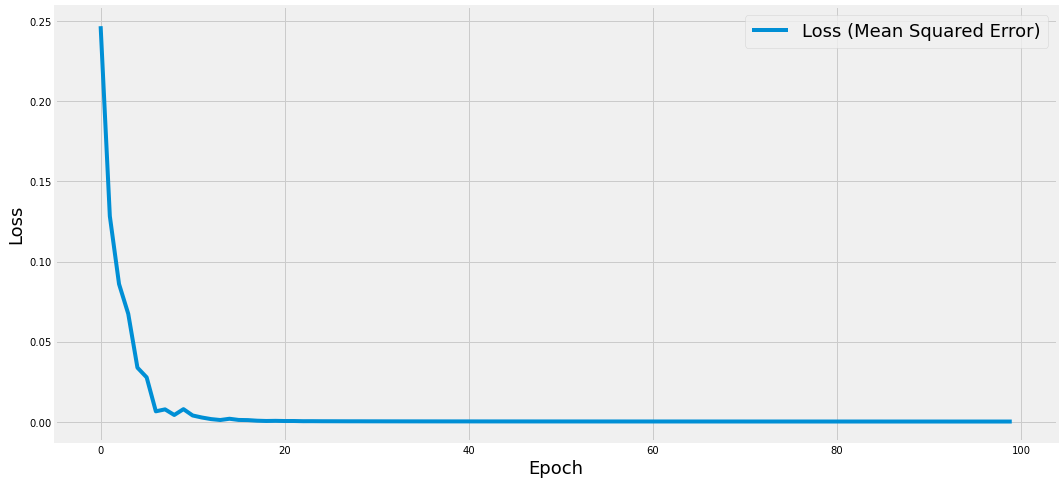

RMSE for feature 4 is: 0.08921713129081893
Epoch 1/100
3/3 [==============================] - 1s 208ms/step - loss: 0.1169
Epoch 2/100
3/3 [==============================] - 1s 228ms/step - loss: 0.0506
Epoch 3/100
3/3 [==============================] - 1s 215ms/step - loss: 0.0474
Epoch 4/100
3/3 [==============================] - 1s 211ms/step - loss: 0.0272
Epoch 5/100
3/3 [==============================] - 1s 214ms/step - loss: 0.0233
Epoch 6/100
3/3 [==============================] - 1s 200ms/step - loss: 0.0166
Epoch 7/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0125
Epoch 8/100
3/3 [==============================] - 1s 192ms/step - loss: 0.0126
Epoch 9/100
3/3 [==============================] - 1s 187ms/step - loss: 0.0103
Epoch 10/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0116
Epoch 11/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0099
Epoch 12/100
3/3 [==============================] - 1s 198ms/step - loss: 0

3/3 [==============================] - 0s 135ms/step - loss: 9.0054e-05
Epoch 99/100
3/3 [==============================] - 0s 140ms/step - loss: 8.3915e-05
Epoch 100/100
3/3 [==============================] - 0s 134ms/step - loss: 7.9060e-05


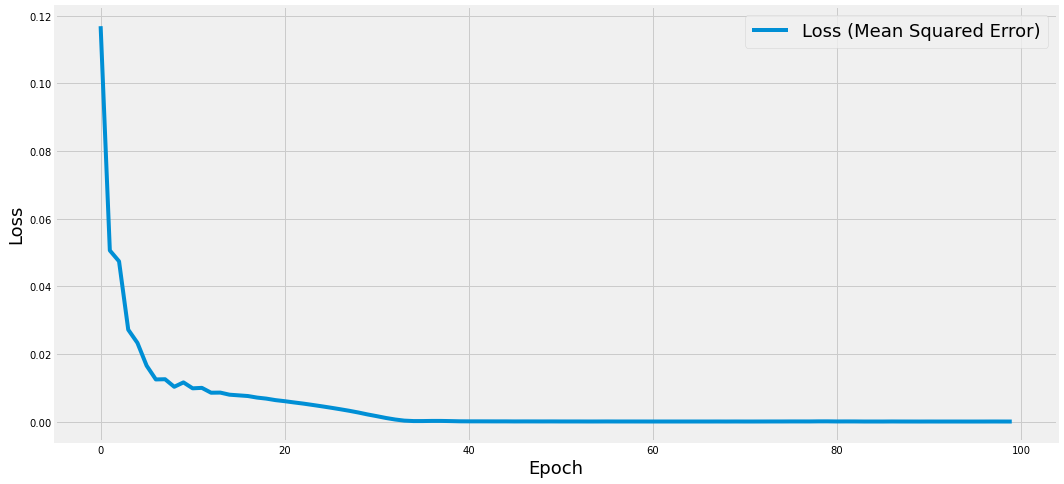

RMSE for feature 5 is: 0.030228296797651197


,x,y,z,x_vv,y_vv,z_vv
0,-38628.224890,-3259.989767,17860.961547,-0.191519,-2.858374,-1.040037
1,-37018.885554,-17683.986292,11254.221872,0.814469,-2.593598,-1.432651
2,-30473.667730,-29748.893793,3163.180087,1.700464,-1.983595,-1.624718
3,-19877.876185,-37813.614721,-5251.411912,2.355915,-1.112286,-1.592533
4,-6624.419644,-40818.265007,-12837.656951,2.702397,-0.093027,-1.343609
...,...,...,...,...,...,...
195,37642.836375,20340.928864,-7672.492361,-0.965930,2.370946,1.754915
196,30410.072665,30791.905055,1817.644988,-1.810919,1.688643,1.825037
197,19482.201053,36998.059703,11199.839953,-2.402057,0.772045,1.649589
198,6276.280206,38217.150115,19152.663254,-2.660733,-0.251207,1.246662


In [5]:
# %%time
# Call for full 6D training

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['0', '1', '2', '3', '4', '5'])

for predicted_feature in range(0,6):
    train_vector(df, predicted_feature)

#Rename predictions df columns from numerals
df_pred.columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv']
df_pred

### Compare and plot results/errors SEPARATELY

In [6]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]
train_df = df[:train_size]

test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38621.084811,-2550.946846,17682.193978,-0.257209,-2.870446,-1.025837
801,-37279.380962,-16940.060722,11242.557363,0.768795,-2.610164,-1.427567
802,-30825.302422,-29006.586493,3208.718635,1.689373,-1.985552,-1.632349
803,-20158.481503,-37068.221540,-5302.080061,2.373066,-1.085660,-1.609145
804,-6770.864726,-40022.999588,-13103.503585,2.726621,-0.041149,-1.362677
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


In [7]:
df_pred.index=test_df.index

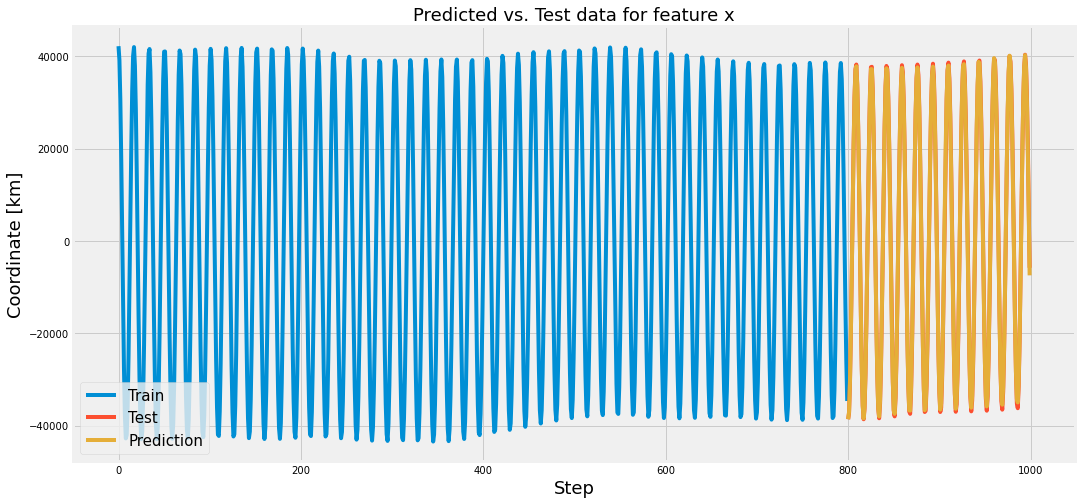

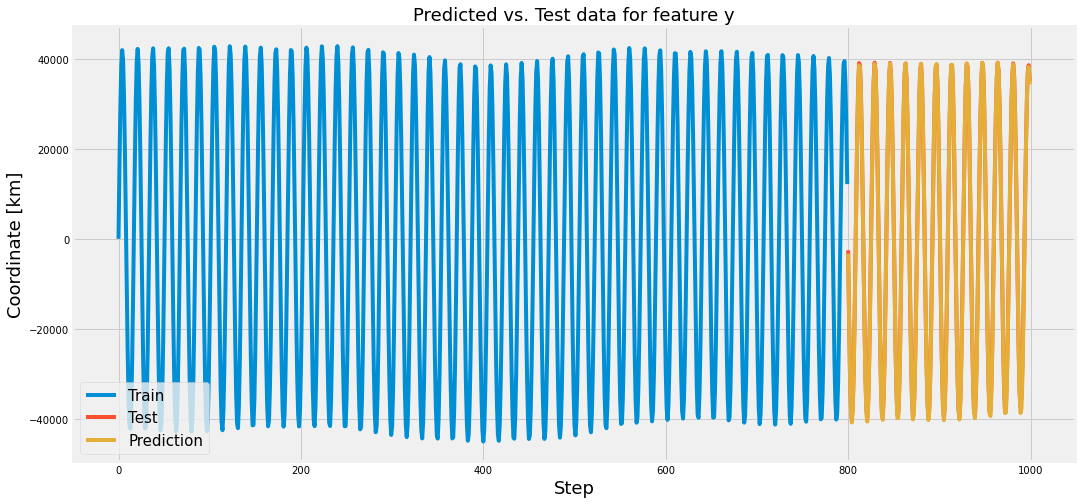

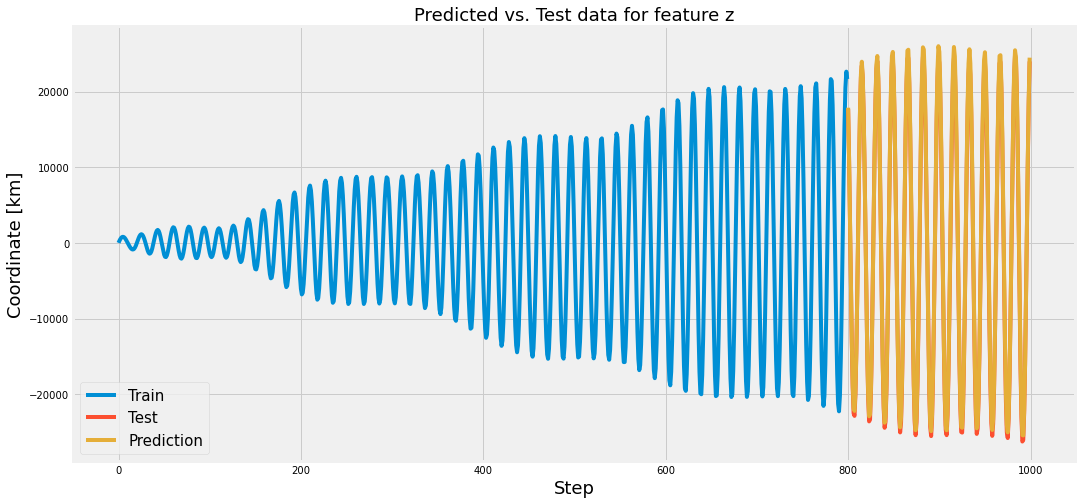

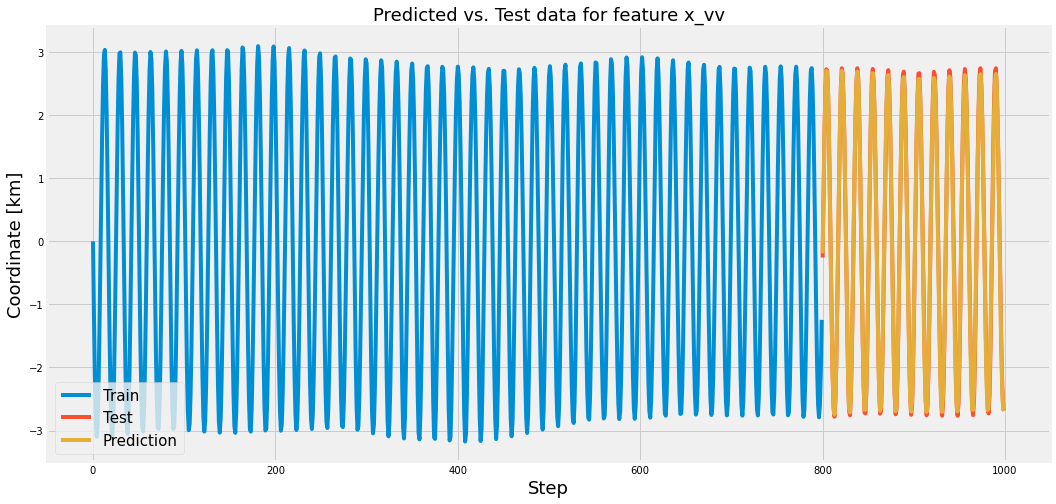

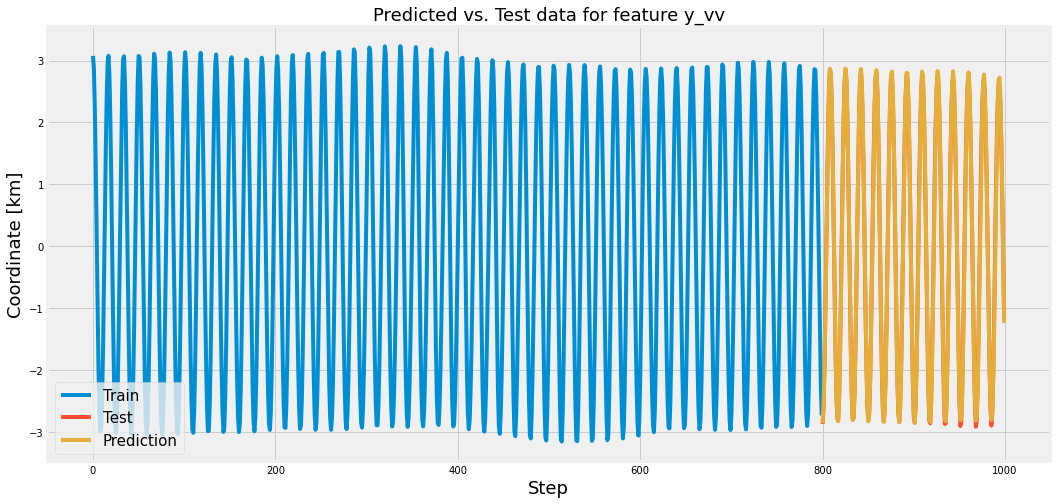

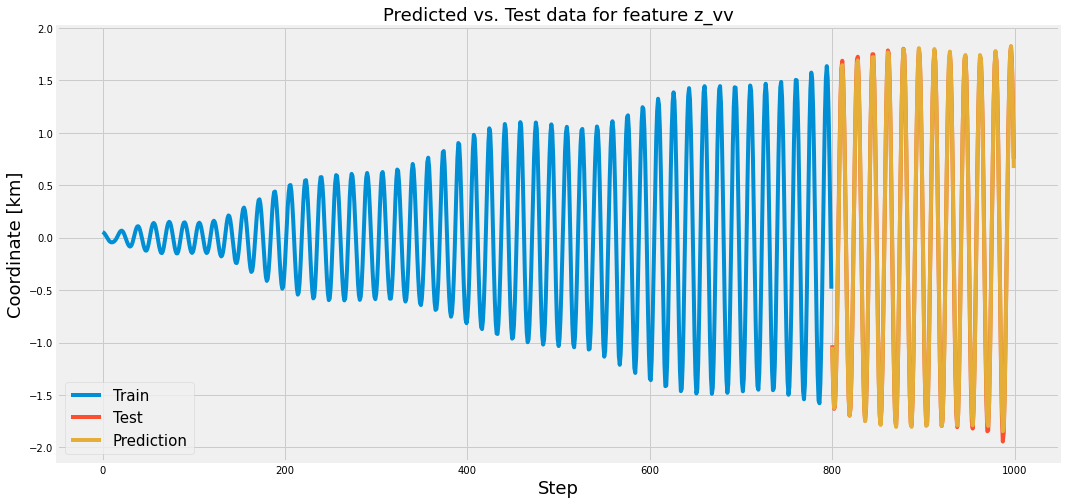

In [8]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature])
    plt.plot(test_df[feature])
    plt.plot(df_pred[feature])

    plt.title(f'Predicted vs. Test data for feature {feature}', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Coordinate [km]', fontsize=18)
    plt.legend(['Train', 'Test', 'Prediction'], loc='lower left', fontsize=15)
    plt.show()


## RMSE:

In [9]:
print('RMSE for all Features:')
print()

for i in list(test_df.columns):
    print(i)
    rmse = np.sqrt(np.mean(((test_df[i] - df_pred[i]) ** 2)))
    print(rmse)

RMSE for all Features:

x
841.9825723688575
y
886.7771159904007
z
737.317727187424
x_vv
0.09421716434724037
y_vv
0.08921713129081892
z_vv
0.030228296797651193


## Absolute errors:

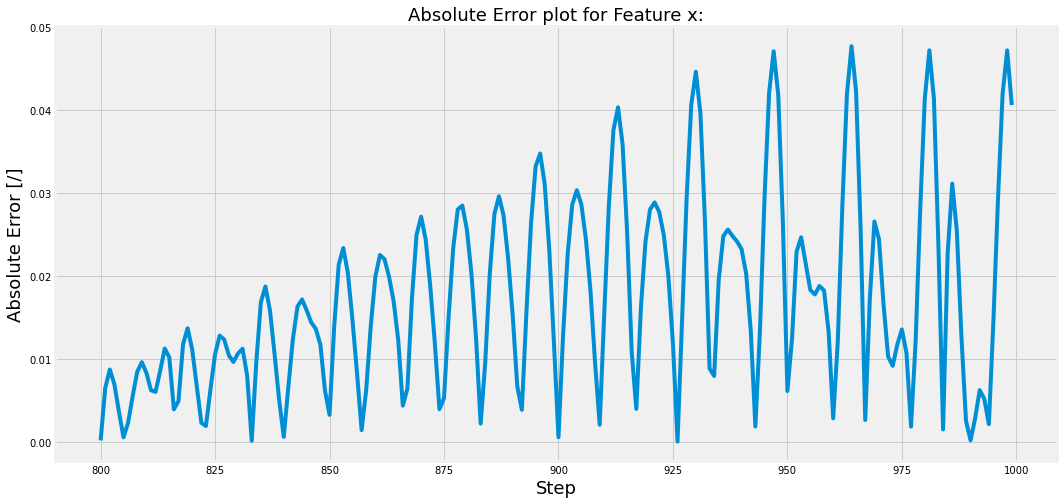

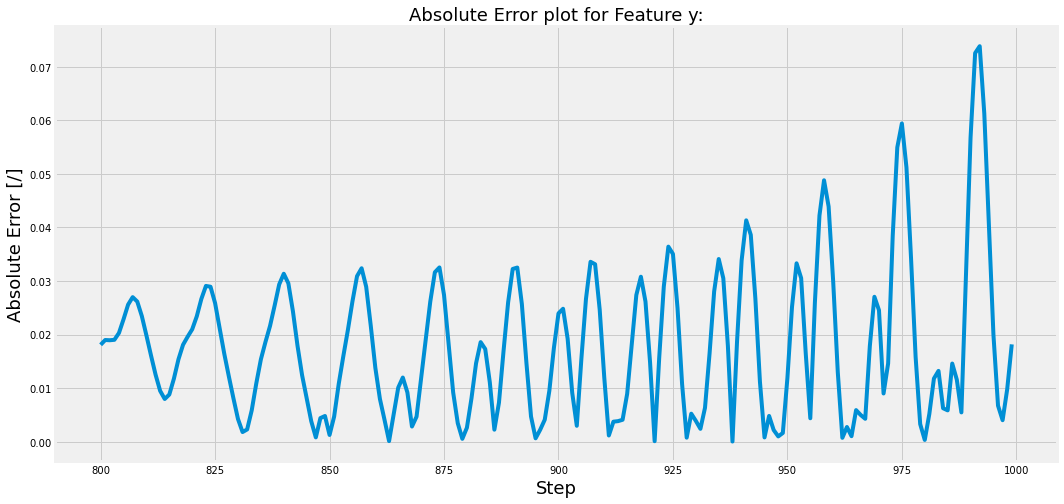

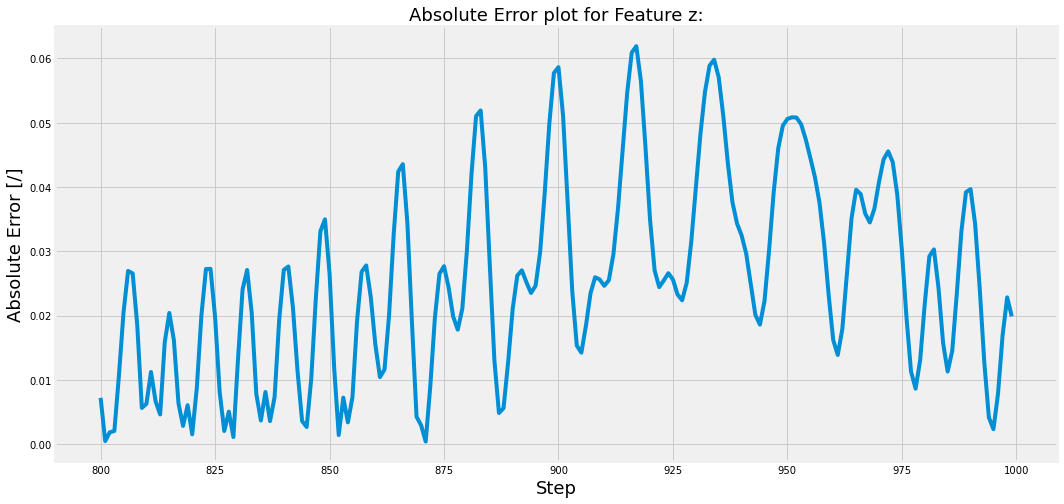

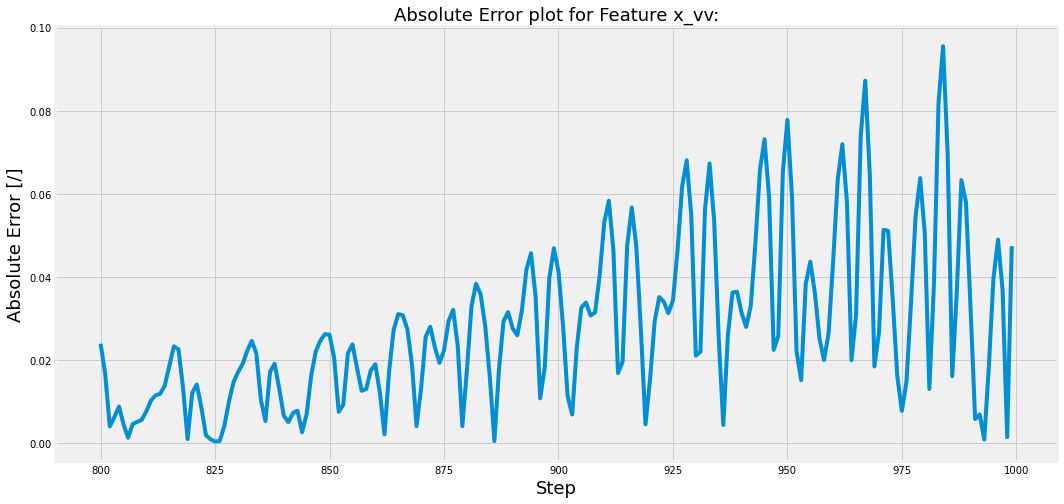

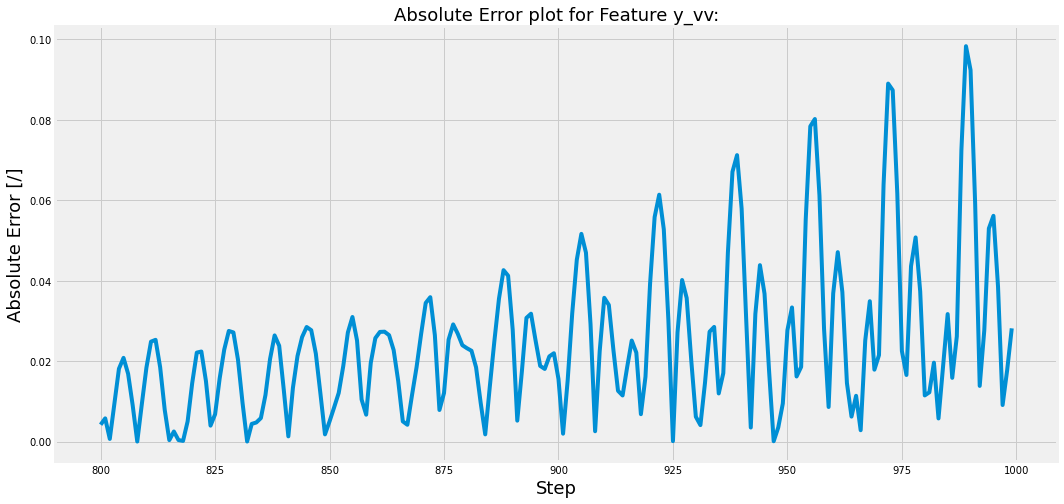

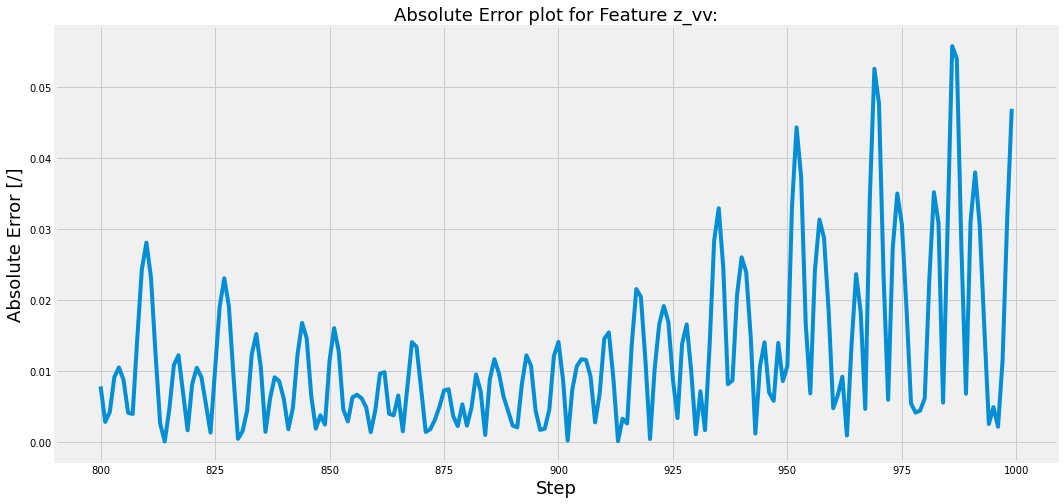

In [10]:
# ABSOLUTE ERRORS:

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/max(test_df[feature]))

    plt.title(f'Absolute Error plot for Feature {feature}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Absolute Error [/]', fontsize=18)
    plt.show()

In [11]:
# AVG ABSOLUTE ERRORS:

print('Mean Absolute Errors:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/max(test_df[i])
    print(abs_err.mean())

Mean Absolute Errors:

x
0.01734136509710033
y
0.017840859725942217
z
0.02538664452943392
x_vv
0.02806422283090474
y_vv
0.024623628844373267
z_vv
0.012290564687073473


## Relative errors:

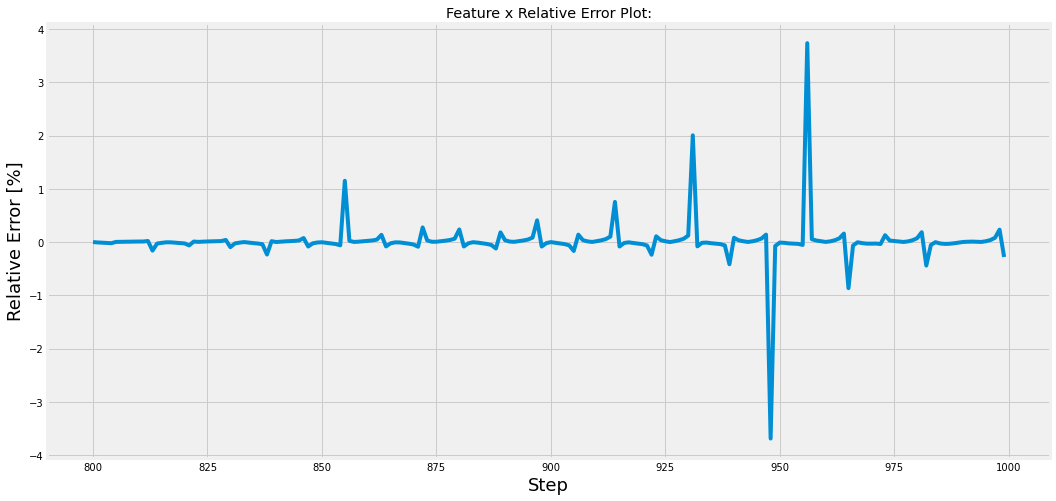

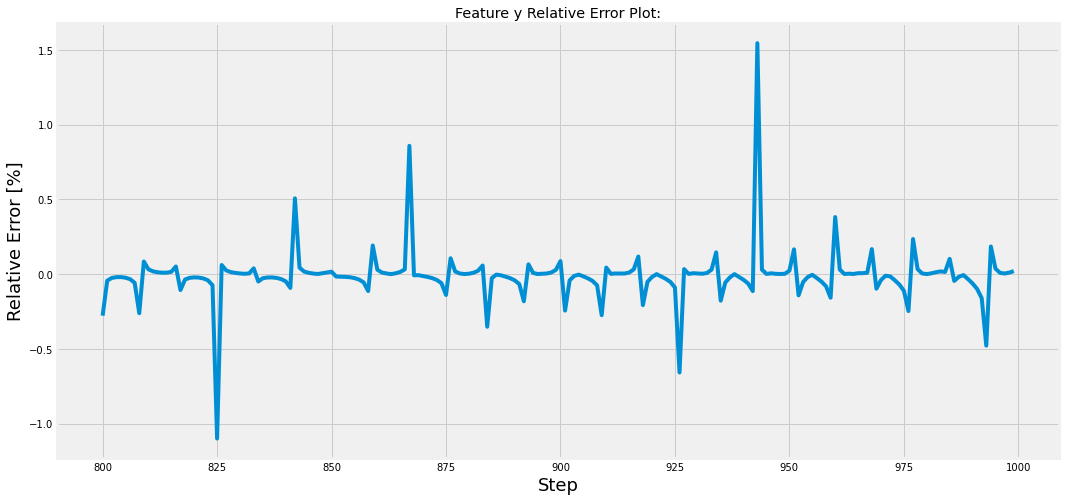

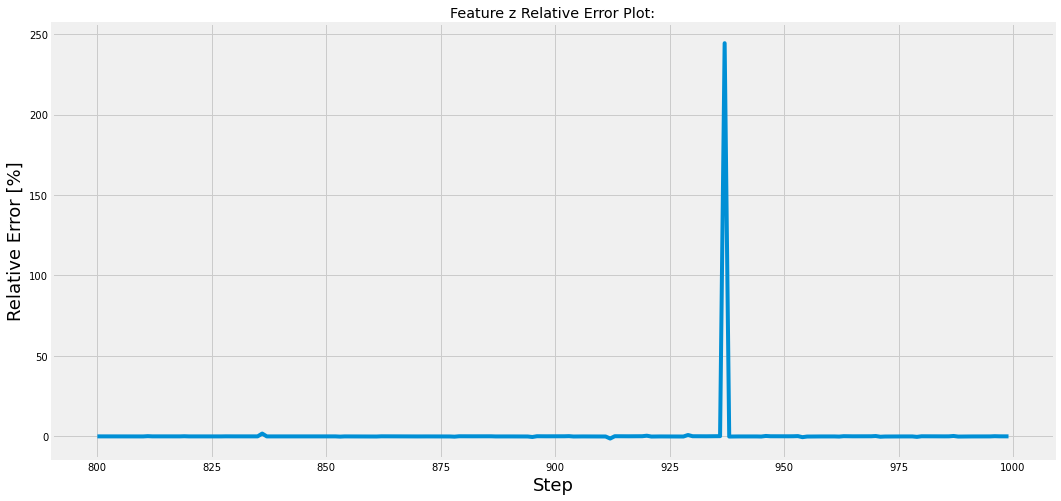

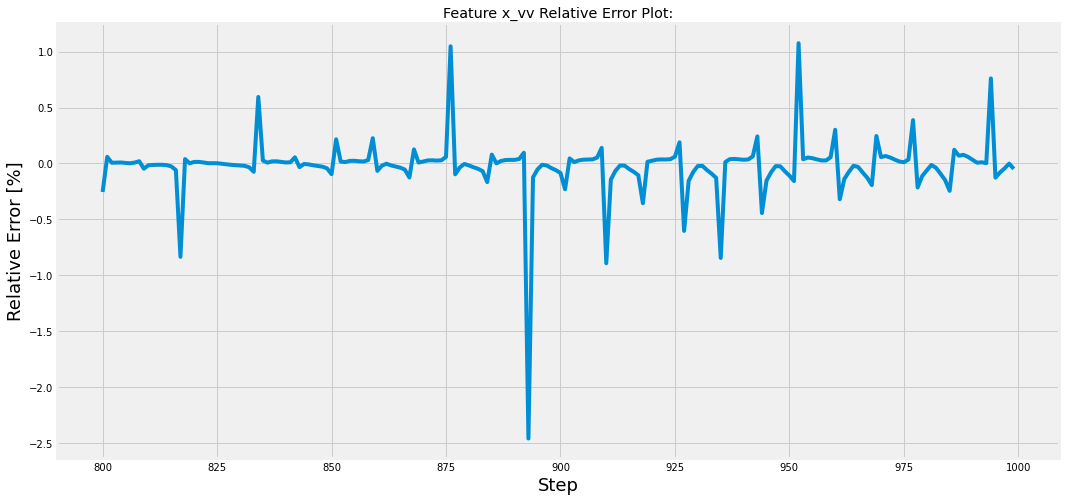

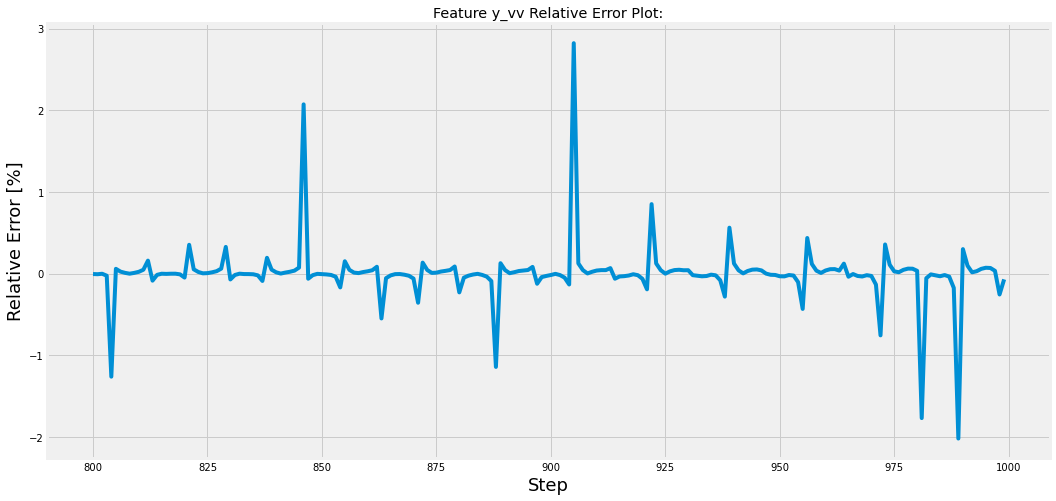

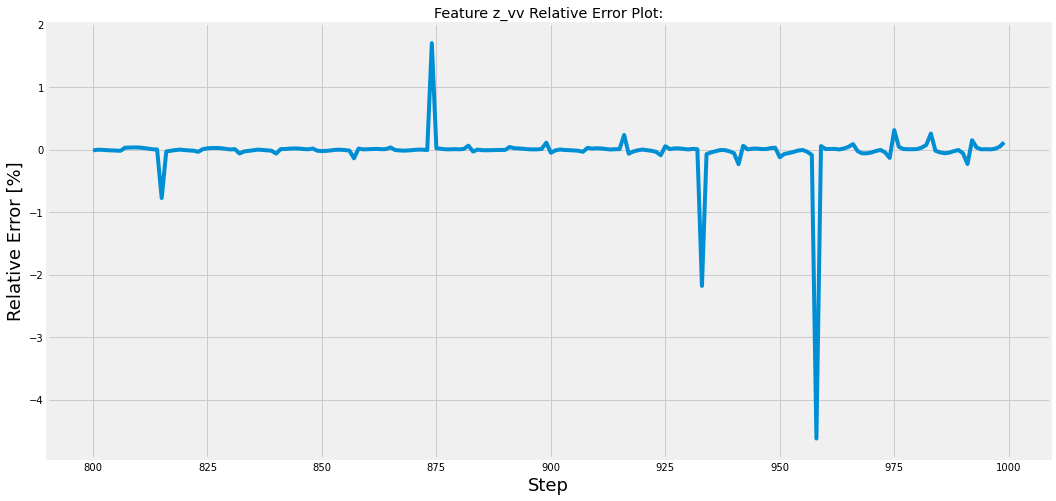

In [12]:
# RELATIVE ERRORS

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/test_df[feature])

    plt.title(f'Feature {feature} Relative Error Plot:')
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Relative Error [%]', fontsize=18)
    plt.show()

In [13]:
# AVG RELATIVE ERRORS:

print('Mean Relative Errors as PERCENTAGE:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/test_df[i]*100
    print(abs_err.mean())

Mean Relative Errors as PERCENTAGE:

x
1.4966473127278324
y
-1.0996875434601783
z
123.31482214650462
x_vv
-2.1905116906223396
y_vv
0.19473121652923311
z_vv
-3.140770746410825


## Compare and Plot 3D trajectories/errors:

### 1. For 3D Position coordinates

<Figure size 432x288 with 0 Axes>

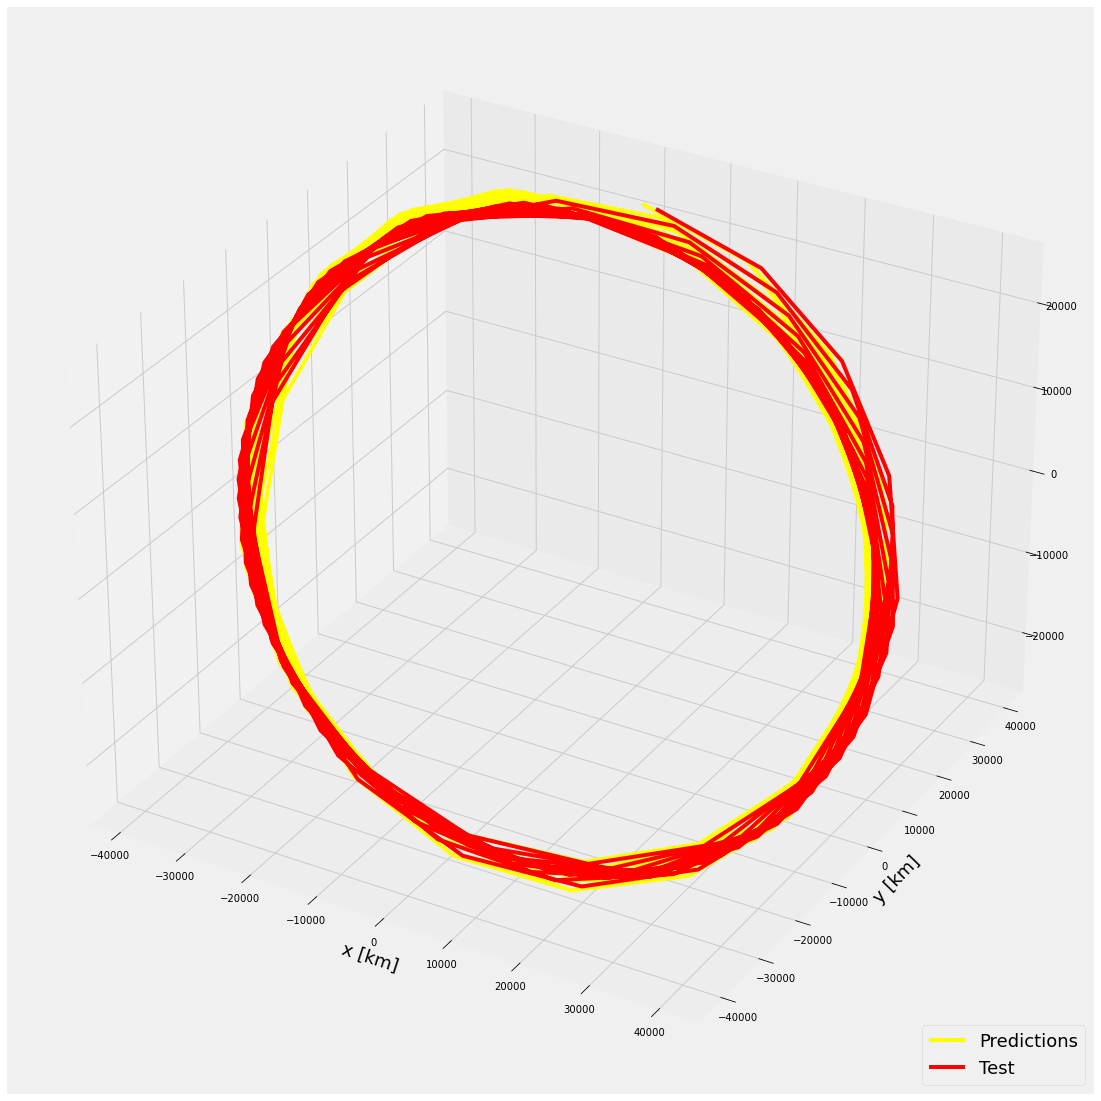

In [15]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'yellow')

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'red')

#plt.title('Predicted vs. Test Orbit 3D Propagation', fontsize=18)
plt.xlabel('x [km]', fontsize=18)
plt.ylabel('y [km]', fontsize=18)
#plt.zlabel('z [m]', fontsize=18)
plt.legend(['Predictions', 'Test'], loc='lower right', fontsize=18)
plt.show()

### 2. For 3D velocity coordinates

## 3D Errors

### 1. Distance Error

https://www.engineeringtoolbox.com/distance-relationship-between-two-points-d_1854.html

In [ ]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

df_err

In [ ]:
import math

# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))
df_err

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_err.distance_error)
plt.title('Distance error for 3D position vectors (r):')
plt.xlabel('Step', fontsize=18)
plt.ylabel('Distance Error [km]', fontsize=18)
plt.show()